In [ ]:
import pickle
import gzip
import numpy as np
import scipy
import pandas as pd
import keras
import keras.layers as layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.layers import Input, LSTM, Dense, Lambda, Conv1D, Conv2D, AveragePooling2D, AveragePooling1D, Flatten, MaxPooling2D, MaxPooling1D, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.applications import imagenet_utils
from keras import backend as K
from time import time
from keras import losses
from sklearn.metrics import  roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, mean_absolute_error
import glob
from PIL import Image
import h5py
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.gaussian_process as gp
import pandas as pd
import pickle
from joblib import dump, load
from sklearn.utils import shuffle
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
import warnings
warnings.filterwarnings('ignore')
!pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jan 24 20:04:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 215, done.
remote: Total 215 (delta 0), reused 0 (delta 0), pack-reused 215
Receiving objects: 100% (215/215), 17.06 MiB | 22.57 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [ ]:
import qmc.tf.layers as layers
import qmc.tf.models as models

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/ICML2021/abalone/data/abalone', header = None, sep = ' ')
X = data.to_numpy()
y = X[:,-1]
X = X[:,0:-1]

In [ ]:
y.shape

(4177,)

In [ ]:
X.shape

(4177, 10)

Los labels van de 1 a 5

In [ ]:
print(max(y))
print(min(y))

5.0
1.0


In [ ]:
y = (y-1)/4
y = np.float64(y)
y = y.reshape((4177,1))
X = np.float64(X)

Normalizando los datos:

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
X_aux, y_aux = shuffle(X, y, random_state=0)

X = X_aux[0:300]
y = y_aux[0:300]

In [ ]:
from scipy.spatial import distance

distances = distance.cdist(X, X, 'euclidean')

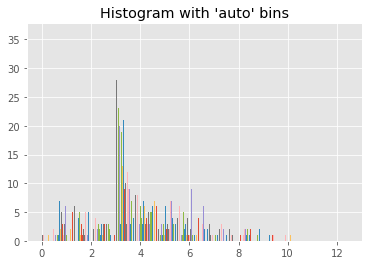

In [ ]:
import matplotlib.pyplot as plt

_ = plt.hist(distances, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")

plt.show()

Sigma:

In [ ]:
print(np.mean(distances))
print(np.median(distances))

3.9699784370806346
3.659927628419985


Gamma:

In [ ]:
print(1/(np.mean(distances)**2))
print(1/(np.median(distances)**2))

0.06344884258006671
0.07465433041330787


In [ ]:
for i in range(5):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/abalone/data/abalone_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/abalone/data/abalone_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((1000,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    X_aux, y_aux = shuffle(X, y, random_state=0)

    X = X_aux[0:300]
    y = y_aux[0:300]

    MAE_opt = 100
    dim_y = 5
    for j in range(25):

        beta = np.random.sample()*25
        gamma = np.random.sample()*0.1
        learning_rate = np.random.sample()*0.001
        alpha = np.random.sample()
        dim_x = 10+np.random.sample()*1024
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/2),int(dim_x/4),int(dim_x/8), int(dim_x/16)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(10, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=10, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
        print('------mae = ',np.mean(MAE))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X_aux
    y_train = y_aux

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((3177,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(10, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=10, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 1
------------ 1 beta= 17.819635392602713 gamma= 0.060137497173223226 learning_rate= 0.0006344852387127153 alpha= 0.37366227666267615 dim_x= 655 num_eig= 40
------mae =  0.31333333333333335
------------ 2 beta= 23.18505593781778 gamma= 0.038461569512378835 learning_rate= 0.00012971692228306875 alpha= 0.7040974009824335 dim_x= 649 num_eig= 81
------mae =  0.31333333333333335
------------ 3 beta= 13.27160157942745 gamma= 0.0272665577141191 learning_rate= 8.380912884833059e-05 alpha= 0.8665507820652969 dim_x= 177 num_eig= 44
------mae =  0.29
------------ 4 beta= 19.33818903620437 gamma= 0.008726752793399939 learning_rate= 0.0008043929451160758 alpha= 0.7940851994361833 dim_x= 506 num_eig= 63
------mae =  0.29333333333333333
------------ 5 beta= 18.77530223358018 gamma= 0.05032626888381772 learning_rate= 0.0005935041428386457 alpha= 0.26188449588975127 dim_x= 632 num_eig= 316
------mae =  0.31999999999999995
------------ 6 beta= 11.764328738166894 